# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1QvJRw67Om5K8_q2vL8LC-l46bOnn-YYL/view?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /Lab_3_Gesture_Recognition.ipynb

In [8]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [10]:
print("age: ", "max = ", (df["age"]).max(), ",min = ", (df["age"]).min(), ",avg = ", (df["age"]).mean())
print("yredu: ", "max = ", (df["yredu"]).max(), ",min = ", (df["yredu"]).min(), ",avg = ", (df["yredu"]).mean())
print("capgain: ", "max = ", (df["capgain"]).max(), ",min = ", (df["capgain"]).min(), ",avg = ", (df["capgain"]).mean())
print("caploss: ", "max = ", (df["caploss"]).max(), ",min = ", (df["caploss"]).min(), ",avg = ", (df["caploss"]).mean())
print("workhr: ", "max = ", (df["workhr"]).max(), ",min = ", (df["workhr"]).min(), ",avg = ", (df["workhr"]).mean())

age:  max =  90 ,min =  17 ,avg =  38.58164675532078
yredu:  max =  16 ,min =  1 ,avg =  10.0806793403151
capgain:  max =  99999 ,min =  0 ,avg =  1077.6488437087312
caploss:  max =  4356 ,min =  0 ,avg =  87.303829734959
workhr:  max =  99 ,min =  1 ,avg =  40.437455852092995


In [11]:
#normalizing using equation; z = (x - min)/(max - min)
df["age"] = (df["age"]-(df["age"]).min()) / ((df["age"]).max() - (df["age"]).min())
df["yredu"] = (df["yredu"]-(df["yredu"]).min()) / ((df["yredu"]).max() - (df["yredu"]).min())
df["capgain"] = (df["capgain"]-(df["capgain"]).min()) / ((df["capgain"]).max() - (df["capgain"]).min())
df["caploss"] = (df["caploss"]-(df["caploss"]).min()) / ((df["caploss"]).max() - (df["caploss"]).min())
df["workhr"] = (df["workhr"]-(df["workhr"]).min()) / ((df["workhr"]).max() - (df["workhr"]).min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [22]:
# hint: you can do something like this in pandas
print("number of male =",sum(df["sex"] == " Male"))
print("number of female =",sum(df["sex"] == " Female"))

print("percentage of people in our data set are female =", (sum(df["sex"] == " Female")/(sum(df["sex"] == " Male")+sum(df["sex"] == " Female")))*100, "%")

number of male = 21790
number of female = 10771
percentage of people in our data set are female = 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [19]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [20]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [23]:
print("number of records =", len(df))
print("number of records with missing features =", len(df_with_missing))

print("percentage of records removed =", (len(df_with_missing)/len(df))*100, "%")

number of records = 32561
number of records with missing features = 1843
percentage of records removed = 5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [24]:
print(set(df_not_missing["work"]))

{' Private', ' Self-emp-not-inc', ' Local-gov', ' Self-emp-inc', ' State-gov', ' Without-pay', ' Federal-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [25]:
data = pd.get_dummies(df_not_missing)

In [26]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [27]:
print("number of columns(features) in data =", len(data.columns))

number of columns(features) in data = 57


Number of columns were generated from the get_dummies function where it transfered strings in the data to 0 and 1 which made multiple columns for one columns in the original dataset.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [28]:
datanp = data.values.astype(np.float32)

In [31]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [30]:
print(cat_index)
print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [32]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [33]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_end = int(datanp.shape[0] * 0.7)
val_end = int(datanp.shape[0] * 0.85)
test_end = int(datanp.shape[0] * 1)

train_dataset = datanp[:train_end]
val_dataset = datanp[train_end:val_end]
test_dataset = datanp[val_end:test_end]

print("size of training dataset =", len(train_dataset))
print("size of validation dataset =", len(val_dataset))
print("size of test dataset =", len(test_dataset))

size of training dataset = 21502
size of validation dataset = 4608
size of test dataset = 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [41]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 37), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(37, 27),
            nn.ReLU(),
            nn.Linear(27, 17)
        )
        self.decoder = nn.Sequential(
            nn.Linear(17, 27), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(27, 37),
            nn.ReLU(),
            nn.Linear(37, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Since we nomalized the data, the values are between 0 to 1. The output of the decoder should be between 0 to 1 because the decoder is reconstructing the inputs. 
Sigmoid activation function forces the output to be between 0 to 1 which is why we need this in the last step of the decoder.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [49]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)

        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)             # compute *average* loss
        val_losses.append(float(val_loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy

        #print accuracy for each epoch
        print("epoch:", epoch+1, "train_accuracy: ", train_acc[epoch], "val_accuracy: ", val_acc[epoch])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [36]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch: 1 train_accuracy:  0.44222242892134067 val_accuracy:  0.4416232638888889
epoch: 2 train_accuracy:  0.4556010293616098 val_accuracy:  0.4544994212962963
epoch: 3 train_accuracy:  0.4598254425944873 val_accuracy:  0.4585503472222222
epoch: 4 train_accuracy:  0.4621973149784516 val_accuracy:  0.46064814814814814
epoch: 5 train_accuracy:  0.4645381824946517 val_accuracy:  0.4625651041666667
epoch: 6 train_accuracy:  0.46563885530028215 val_accuracy:  0.4652777777777778
epoch: 7 train_accuracy:  0.5114485474219452 val_accuracy:  0.5112485532407407
epoch: 8 train_accuracy:  0.5430037515889995 val_accuracy:  0.5436921296296297
epoch: 9 train_accuracy:  0.5562738349920937 val_accuracy:  0.5554832175925926
epoch: 10 train_accuracy:  0.561490403993427 val_accuracy:  0.5597149884259259
epoch: 11 train_accuracy:  0.5650792174371376 val_accuracy:  0.5648148148148148
epoch: 12 train_accuracy:  0.5636684959538648 val_accuracy:  0.5635489004629629
epoch: 13 train_accuracy:  0.565908597649831 va

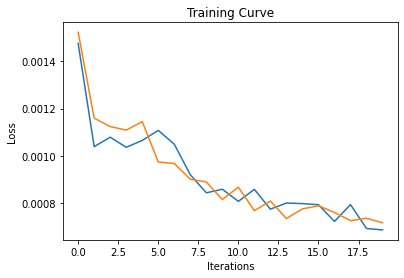

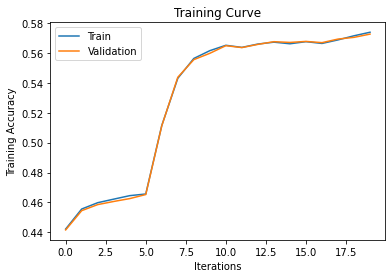

Final Training Accuracy: 0.5737993364958298
Final Validation Accuracy: 0.5725549768518519


In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

autoencoder = AutoEncoder()

train(autoencoder, train_loader, val_loader, num_epochs=20, learning_rate=0.0001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [51]:
def train_no_curves(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)

        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)             # compute *average* loss
        val_losses.append(float(val_loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy

        #print accuracy for each epoch
        print("epoch:", epoch+1, "train_accuracy: ", train_acc[epoch], "val_accuracy: ", val_acc[epoch])

In [52]:
#batch_size: 64, num_epochs: 30, lr: 0.0001
#Used same parameters from part c, except increased the number of epochs
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

autoencoder = AutoEncoder()

train_no_curves(autoencoder, train_loader, val_loader, num_epochs=30, learning_rate=0.0001)

epoch: 1 train_accuracy:  0.44222242892134067 val_accuracy:  0.4416232638888889
epoch: 2 train_accuracy:  0.45540724893808326 val_accuracy:  0.45417390046296297
epoch: 3 train_accuracy:  0.4598331938114284 val_accuracy:  0.4585503472222222
epoch: 4 train_accuracy:  0.461856261433045 val_accuracy:  0.46043113425925924
epoch: 5 train_accuracy:  0.4646001922301801 val_accuracy:  0.46263744212962965
epoch: 6 train_accuracy:  0.4656466065172232 val_accuracy:  0.4650607638888889
epoch: 7 train_accuracy:  0.48466034167364275 val_accuracy:  0.48343460648148145
epoch: 8 train_accuracy:  0.5388490993085915 val_accuracy:  0.5395326967592593
epoch: 9 train_accuracy:  0.5485458717018572 val_accuracy:  0.5487557870370371
epoch: 10 train_accuracy:  0.5505069295879453 val_accuracy:  0.5491898148148148
epoch: 11 train_accuracy:  0.5638157690757449 val_accuracy:  0.5629340277777778
epoch: 12 train_accuracy:  0.563443710662574 val_accuracy:  0.5628978587962963
epoch: 13 train_accuracy:  0.564017300716212

In [53]:
#results were slightly better than partc, however did not make a huge difference
#lowered the learning rate, decreased the batch_size, and decreased the number of epochs
#batch_size: 32, num_epochs: 20, lr: 0.001
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

autoencoder = AutoEncoder()

train_no_curves(autoencoder, train_loader, val_loader, batch_size=32, num_epochs=20, learning_rate=0.001)

epoch: 1 train_accuracy:  0.5777369547018882 val_accuracy:  0.5767867476851852
epoch: 2 train_accuracy:  0.5914023501689766 val_accuracy:  0.5910373263888888
epoch: 3 train_accuracy:  0.6054398040492357 val_accuracy:  0.6003689236111112
epoch: 4 train_accuracy:  0.5911000527082751 val_accuracy:  0.5880353009259259
epoch: 5 train_accuracy:  0.6044476482807801 val_accuracy:  0.5997178819444444
epoch: 6 train_accuracy:  0.609369671038353 val_accuracy:  0.6032986111111112
epoch: 7 train_accuracy:  0.6136793476575823 val_accuracy:  0.6102068865740741
epoch: 8 train_accuracy:  0.6078271788670822 val_accuracy:  0.6042028356481481
epoch: 9 train_accuracy:  0.6140824109385173 val_accuracy:  0.6085792824074074
epoch: 10 train_accuracy:  0.5952392025548011 val_accuracy:  0.5912543402777778
epoch: 11 train_accuracy:  0.6173534244876445 val_accuracy:  0.6126302083333334
epoch: 12 train_accuracy:  0.6279570892630143 val_accuracy:  0.6231915509259259
epoch: 13 train_accuracy:  0.613129011254767 val_a

In [54]:
#since the results were improved with the parameters chosen above, 
#made a small change - decided to increase the number of epochs
#batch_size: 32, num_epochs: 30, lr: 0.001
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

autoencoder = AutoEncoder()

train_no_curves(autoencoder, train_loader, val_loader, batch_size=32, num_epochs=30, learning_rate=0.001)

epoch: 1 train_accuracy:  0.5697144451678914 val_accuracy:  0.5701678240740741
epoch: 2 train_accuracy:  0.5909915356711004 val_accuracy:  0.5898799189814815
epoch: 3 train_accuracy:  0.6045794189687781 val_accuracy:  0.6027560763888888
epoch: 4 train_accuracy:  0.6079977056397855 val_accuracy:  0.6039496527777778
epoch: 5 train_accuracy:  0.6119740799305491 val_accuracy:  0.6072771990740741
epoch: 6 train_accuracy:  0.6167255759154188 val_accuracy:  0.6137876157407407
epoch: 7 train_accuracy:  0.6115787678665551 val_accuracy:  0.6078197337962963
epoch: 8 train_accuracy:  0.620004340681487 val_accuracy:  0.6141854745370371
epoch: 9 train_accuracy:  0.6140126499860478 val_accuracy:  0.6100983796296297
epoch: 10 train_accuracy:  0.6101913000341054 val_accuracy:  0.6069516782407407
epoch: 11 train_accuracy:  0.5939680029764673 val_accuracy:  0.5919415509259259
epoch: 12 train_accuracy:  0.6039360679626702 val_accuracy:  0.6015263310185185
epoch: 13 train_accuracy:  0.6132452795088829 val_

In [66]:
#increased batch size along with the learning rate and decreased number of epochs
#batch_size: 64, num_epochs: 20, lr: 0.005

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

best_model = AutoEncoder()

train_no_curves(best_model, train_loader, val_loader, batch_size=64, num_epochs=20, learning_rate=0.005)

epoch: 1 train_accuracy:  0.5945881003317521 val_accuracy:  0.5910011574074074
epoch: 2 train_accuracy:  0.6106796267013921 val_accuracy:  0.6040219907407407
epoch: 3 train_accuracy:  0.6168418441695346 val_accuracy:  0.6096643518518519
epoch: 4 train_accuracy:  0.5951616903853905 val_accuracy:  0.5916883680555556
epoch: 5 train_accuracy:  0.6225002325365082 val_accuracy:  0.6196469907407407
epoch: 6 train_accuracy:  0.6136715964406412 val_accuracy:  0.6085431134259259
epoch: 7 train_accuracy:  0.6304684835519176 val_accuracy:  0.6255787037037037
epoch: 8 train_accuracy:  0.6283446501100672 val_accuracy:  0.6225405092592593
epoch: 9 train_accuracy:  0.6283679037608905 val_accuracy:  0.6230830439814815
epoch: 10 train_accuracy:  0.638304963879329 val_accuracy:  0.6332465277777778
epoch: 11 train_accuracy:  0.6289724986822931 val_accuracy:  0.6236617476851852
epoch: 12 train_accuracy:  0.6347471553033827 val_accuracy:  0.6311125578703703
epoch: 13 train_accuracy:  0.6313986295848448 val_

Last set of parameters recorded the best train and validation accuracy

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [67]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

test_acc = get_accuracy(best_model, test_loader)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.6278573495370371


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [71]:
#most common value model
mcv = {}

for i in df_not_missing.columns:
    mcv[i] = df_not_missing[i].value_counts().idxmax()

#baseline acc is when (correct prediction)/total
baseline_acc = sum(df_not_missing["marriage"] == mcv["marriage"])/len(df_not_missing)

print("Baseline model accuracy:", baseline_acc) 

Baseline model accuracy: 0.4667947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

My model from part (a) performs noticeably better than the baseline(mcv) model from part(b) by comparing the test accuracies in both models. 

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [73]:
get_features(test_dataset[0])

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}

Marriage, sex, and relationship does not say much about the person's education level, however it is somewhat reasonable for a human to guess one's education level based on one's work and occupation.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [78]:
test_person = torch.from_numpy(test_dataset[0])

pred = best_model(test_person)
pred = pred.detach().numpy()

result = get_feature(pred, "edu")

print("My model's prediction:", result)

My model's prediction: Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [79]:
print("Baseline model's prediction:", mcv["edu"])

Baseline model's prediction:  HS-grad
